## Fetching Data from NBA API

In [2]:
import pandas as pd
import numpy as np
import logging
from nba_api.stats.endpoints import playergamelog, leaguedashteamstats
from nba_api.stats.static import players, teams

class NBADataProcessor:
    def __init__(self, player_id: int, seasons: list[str] = ['2023-24', '2024-25']):
        """
        Initialize NBA data processor for a specific player

        :param player_id: NBA player ID
        :param seasons: List of seasons to process
        """
        self.player_id = player_id
        self.seasons = seasons
        self.team_dict = {
            'ATL': 1610612737, 'BOS': 1610612738, 'CLE': 1610612739,
            'NOP': 1610612740, 'CHI': 1610612741, 'DAL': 1610612742,
            'DEN': 1610612743, 'GSW': 1610612744, 'HOU': 1610612745,
            'LAC': 1610612746, 'LAL': 1610612747, 'MIA': 1610612748,
            'MIL': 1610612749, 'MIN': 1610612750, 'BKN': 1610612751,
            'NYK': 1610612752, 'ORL': 1610612753, 'IND': 1610612754,
            'PHI': 1610612755, 'PHX': 1610612756, 'POR': 1610612757,
            'SAC': 1610612758, 'SAS': 1610612759, 'OKC': 1610612760,
            'TOR': 1610612761, 'UTA': 1610612762, 'MEM': 1610612763,
            'WAS': 1610612764, 'DET': 1610612765, 'CHA': 1610612766
        }

        # Configure logging
        logging.basicConfig(
            filename='nba_data_processing.log',
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )

    def fetch_player_game_logs(self, season: str) -> pd.DataFrame:
        """
        Fetch game logs for a specific season

        :param season: NBA season
        :return: DataFrame of player game logs
        """
        try:
            game_log = playergamelog.PlayerGameLog(
                player_id=self.player_id,
                season=season,
                season_type_all_star='Regular Season'
            )
            df = game_log.get_data_frames()[0]

            # Add home/away status and opponent information
            df['Home'] = df['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)
            df['Opponent'] = df['MATCHUP'].apply(lambda x: x.split()[-1])
            df['opponent_id'] = df['Opponent'].map(self.team_dict)

            return df
        except Exception as e:
            logging.error(f"Error fetching game logs for season {season}: {e}")
            return pd.DataFrame()

    def fetch_team_defensive_stats(self, season: str) -> pd.DataFrame:
        """
        Fetch team defensive statistics

        :param season: NBA season
        :return: DataFrame of team defensive stats
        """
        try:
            stats = leaguedashteamstats.LeagueDashTeamStats(
                season=season,
                season_type_all_star='Regular Season',
                measure_type_detailed_defense='Opponent',
                per_mode_detailed='PerGame',
                player_position_abbreviation_nullable='G'
            )
            return stats.get_data_frames()[0]
        except Exception as e:
            logging.error(f"Error fetching defensive stats for season {season}: {e}")
            return pd.DataFrame()

    def process_data(self) -> pd.DataFrame:
        """
        Process game logs across multiple seasons

        :return: Combined and processed DataFrame
        """
        # Collect game logs for all specified seasons
        all_season_logs = []
        for season in self.seasons:
            game_log = self.fetch_player_game_logs(season)
            defensive_stats = self.fetch_team_defensive_stats(season)

            # Merge game logs with defensive stats
            merged_df = game_log.merge(
                defensive_stats,
                left_on='opponent_id',
                right_on='TEAM_ID',
                how='left',
                suffixes=('_player', '_team')
            )

            all_season_logs.append(merged_df)

        # Combine all season logs
        combined_df = pd.concat(all_season_logs, ignore_index=True)

        # Date and rolling feature processing
        combined_df['GAME_DATE'] = pd.to_datetime(combined_df['GAME_DATE'], format='%b %d, %Y')
        combined_df.sort_values('GAME_DATE', inplace=True)

        # Calculate advanced features
        combined_df['PTS_Last_5'] = combined_df['PTS'].rolling(window=5).mean()
        combined_df['Rest_Days'] = combined_df['GAME_DATE'].diff().dt.days.clip(upper=7).fillna(0)

        # Define improved feature list
        features = [
            # Player Performance Metrics
            'MIN_player',      # Minutes played
            'FGA',             # Field goal attempts
            'FG_PCT',          # Field goal percentage
            'FG3A',            # 3-point attempts
            'FG3_PCT',         # 3-point percentage
            'FTM',             # Free throws made

            # Context Features
            'Home',            # Home/Away game
            'Rest_Days',       # Days of rest
            'PTS_Last_5',      # Rolling 5-game points average

            # Opponent Defensive Metrics
            'opponent_id',     # Opponent team ID
            'OPP_PTS',         # Opponent points allowed
            'OPP_FG_PCT',      # Opponent field goal percentage allowed
            'OPP_FG3_PCT',     # Opponent 3-point percentage allowed

        ]

        target = 'PTS'

        # Drop rows with missing values
        combined_df.dropna(subset=features + [target], inplace=True)

        # Log dataset state
        logging.info(f"Dataset shape after feature engineering: {combined_df.shape}")
        logging.info(f"Features used: {features}")

        return combined_df[features + [target]]

    def save_to_csv(self, df: pd.DataFrame, filename: str = 'player_game_stats.csv'):
        """
        Save processed DataFrame to CSV

        :param df: DataFrame to save
        :param filename: Output filename
        """
        try:
            df.to_csv(filename, index=False)
            logging.info(f"Saved data to {filename}")
            print(f"CSV file {filename} saved successfully!")
        except Exception as e:
            logging.error(f"Error saving CSV: {e}")

# Example usage
if __name__ == "__main__":
    # Steph Curry's player ID
    processor = NBADataProcessor(201939)

    # Process and save data
    processed_data = processor.process_data()
    processor.save_to_csv(processed_data, 'steph_curry_game_stats.csv')

CSV file steph_curry_game_stats.csv saved successfully!


In [8]:


# Configure logging
logging.basicConfig(filename='data_processing.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Dictionary of team abbreviations to IDs
team_dict = {
    'ATL': 1610612737, 'BOS': 1610612738, 'CLE': 1610612739,
    'NOP': 1610612740, 'CHI': 1610612741, 'DAL': 1610612742,
    'DEN': 1610612743, 'GSW': 1610612744, 'HOU': 1610612745,
    'LAC': 1610612746, 'LAL': 1610612747, 'MIA': 1610612748,
    'MIL': 1610612749, 'MIN': 1610612750, 'BKN': 1610612751,
    'NYK': 1610612752, 'ORL': 1610612753, 'IND': 1610612754,
    'PHI': 1610612755, 'PHX': 1610612756, 'POR': 1610612757,
    'SAC': 1610612758, 'SAS': 1610612759, 'OKC': 1610612760,
    'TOR': 1610612761, 'UTA': 1610612762, 'MEM': 1610612763,
    'WAS': 1610612764, 'DET': 1610612765, 'CHA': 1610612766
}

player_id = 201939  # Steph Curry's player ID
season = '2024-25'
season_type_all_star='Regular Season'

# Fetch player game log
game_log = playergamelog.PlayerGameLog(player_id=player_id, season=season, season_type_all_star=season_type_all_star)
df = game_log.get_data_frames()[0]

# Add home/away status and opponent ID
df['Home'] = df['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)
df['Opponent'] = df['MATCHUP'].apply(lambda x: x.split()[-1])
df['opponent_id'] = df['Opponent'].map(team_dict)

# Fetch defensive stats vs. position
stats = leaguedashteamstats.LeagueDashTeamStats(
    season=season,
    season_type_all_star=season_type_all_star,
    measure_type_detailed_defense='Opponent',
    per_mode_detailed='PerGame',
    player_position_abbreviation_nullable='G'
)
defense_stats_df = stats.get_data_frames()[0]

# Merge player game logs with defensive stats using suffixes
df = df.merge(defense_stats_df, left_on='opponent_id', right_on='TEAM_ID', how='left', suffixes=('_player', '_team'))

# Save to CSV
df.to_csv('steph_curry_game_stats_{}.csv'.format(season), index=False)

# Combine CSVs
df_23 = pd.read_csv('steph_curry_game_stats_2023-24.csv')
df_24 = pd.read_csv('steph_curry_game_stats_2024-25.csv')
combined_df = pd.concat([df_24, df_23], ignore_index=True)

# Ensure data is sorted by game date (ascending order)
combined_df['GAME_DATE'] = pd.to_datetime(combined_df['GAME_DATE'], format='%b %d, %Y')
combined_df.sort_values('GAME_DATE', inplace=True)

# Calculate rolling averages for points (rolling window of 5 games)
combined_df['PTS_Last_5'] = combined_df['PTS'].rolling(window=5).mean()

# Calculate rest days
combined_df['Rest_Days'] = combined_df['GAME_DATE'].diff().dt.days.clip(upper=7)
combined_df['Rest_Days'] = combined_df['Rest_Days'].fillna(0)


# Select relevant features and target
features = [
    'MIN_player',  # Player minutes
    'FGA',         # Field goal attempts
    'FG_PCT',      # Field goal percent
    'FG3A',        # 3-Point attempts
    'FG3_PCT',     # 3-Point percent
    'FTM',         # Free throws made
    'Home',        # Home/Away indicator
    'Rest_Days',   # Days of rest before the game
    'PTS_Last_5',# Rolling average of points
    'opponent_id', # Opponent team id
    'OPP_PTS',     # Opponent defense vs position
    'OPP_FG_PCT',  # Opponent field goal percent
]
target = 'PTS'

# Drop rows with missing values for numerical features and target
combined_df.dropna(subset=features + [target], inplace=True)

# Log dataset state
logging.info(f"Dataset shape after feature engineering: {combined_df.shape}")
logging.info(f"Columns: {list(combined_df.columns)}")

# Save to CSV
combined_df.to_csv('steph_curry_combined_game_stats.csv', index=False)
print("CSV file saved successfully!")


CSV file saved successfully!


## Obtain opponent stats vs position

In [7]:
stats = leaguedashteamstats.LeagueDashTeamStats(
    season=season,
    season_type_all_star=season_type_all_star,
    measure_type_detailed_defense='Opponent',
    per_mode_detailed='PerGame',
    player_position_abbreviation_nullable='G'
)

defense_stats_df = stats.get_data_frames()[0]

# Save to CSV
defense_stats_df.to_csv('defensive_stats_guard_{}.csv'.format(season), index=False)
print("CSV file saved successfully!")

CSV file saved successfully!


## Training Model and Evaluation

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load the CSV data
data = pd.read_csv('steph_curry_combined_game_stats.csv')

# Define features and target variable
X = data[features]
y = data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

# Print the actual and predicted values
print("Actual values in test set:", y_test.values)
print("Predicted values:", predictions)


Mean Squared Error: 3.315691938884057
Actual values in test set: [24 21 25 27 26 17 35 37 23 29  9 15 46 19 31 15 25]
Predicted values: [22.77982514 21.89317605 28.52034831 28.37825351 26.41614401 14.00377353
 34.4260279  35.84784176 21.9979497  29.84247724  5.67389352 15.67686198
 46.18869836 17.7762724  28.77746443 15.88571736 22.08658254]


## Visualisation

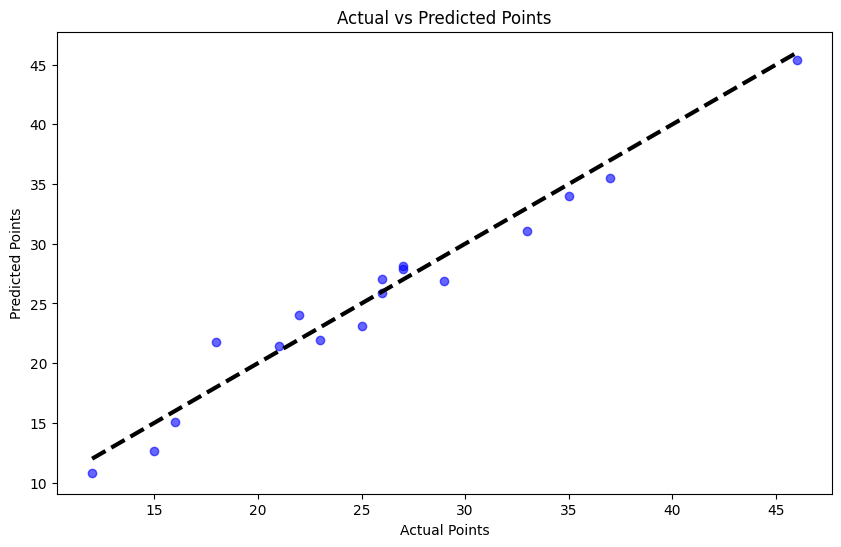

In [4]:
import matplotlib.pyplot as plt
# Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Actual vs Predicted Points')
plt.show()


## Feature Selection - correlation matrix

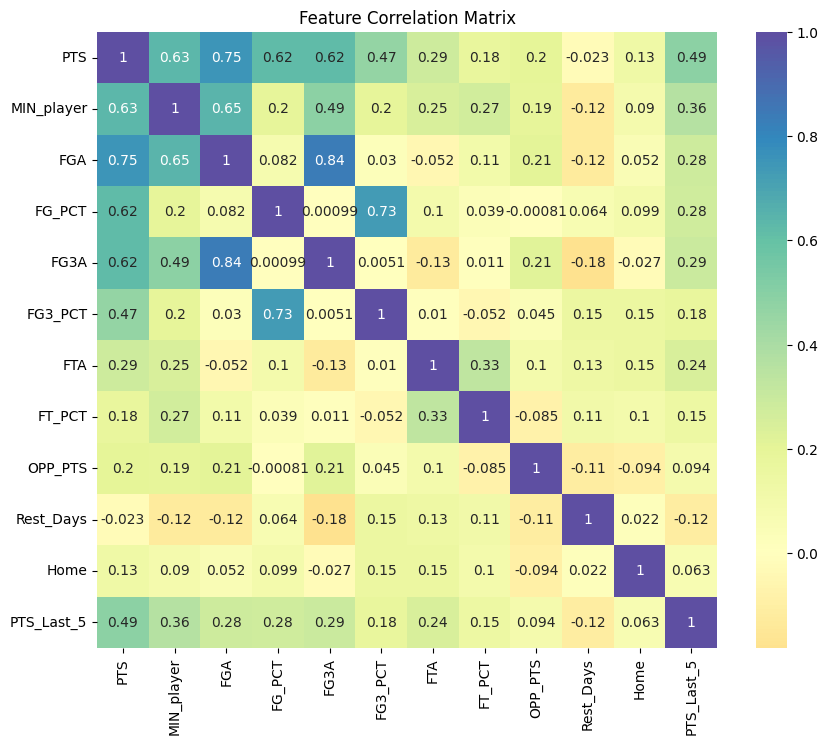

In [5]:
import seaborn as sns
# Select relevant features for scoring prediction
features_to_check = [
    'PTS',  # Target variable
    'MIN_player',  # Minutes played
    'FGA',  # Field goal attempts
    'FG_PCT',  # Field goal percentage
    'FG3A',  # 3-point attempts
    'FG3_PCT',  # 3-point percentage
    'FTA',  # Free throw attempts
    'FT_PCT',  # Free throw percentage
    'OPP_PTS',  # Opponent points
    'Rest_Days',  # Days of rest
    'Home',  # Home/Away
    'PTS_Last_5'  # Last 5 games scoring average
]

correlation_matrix = combined_df[features_to_check].corr()

#create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Spectral', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

## Prediction for Future Games

In [6]:
# Example mock data for an upcoming game with the Home feature
mock_data = {
    'MIN_player': [30],
    'FGM': [8],
    'FTM': [5],
    'REB': [3],
    'AST': [4],
    'STL': [0],
    'BLK': [0],
    'Home': [1],  # Example: playing at home
    'opponent_id': [1610612740],
    'OPP_PTS': [52.4],
    'OPP_REB': [19.8],
    'OPP_AST': [12.3],

}
mock_df = pd.DataFrame(mock_data)

# Predict points for the next game
prediction = model.predict(mock_df)
print("Predicted Points for the next game:", prediction[0])


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- AST
- BLK
- FGM
- REB
- STL
Feature names seen at fit time, yet now missing:
- FG3A
- FG3_PCT
- FGA
- FG_PCT
- OPP_FG_PCT
- ...
